## Introduction


Predict whether a client will subscribe to a term deposit (indicated by the variable "y" as "yes" or "no"). Your task is to build a predictive model that determines the likelihood of a client subscribing to a term deposit based on the features provided in the datase

### Import packages


In [1]:
#data cleaning and manipulation packages
import numpy as np
import pandas as pd

# Important imports for preprocessing, modeling, and evaluation.
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score,average_precision_score, f1_score,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score, precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay

# Visualization package imports.
import matplotlib.pyplot as plt
import seaborn as sns

### Load data and inspect

In [2]:
term_data=pd.read_csv('bank-additional-full.csv',sep=';')
term_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
#check for data completeness
term_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

##### Check for unique values in some column

In [4]:
term_data['poutcome'].unique()

array(['nonexistent', 'failure', 'success'], dtype=object)

In [5]:
term_data['marital'].unique()

array(['married', 'single', 'divorced', 'unknown'], dtype=object)

In [6]:
term_data['contact'].unique()

array(['telephone', 'cellular'], dtype=object)

##### Distribution of age

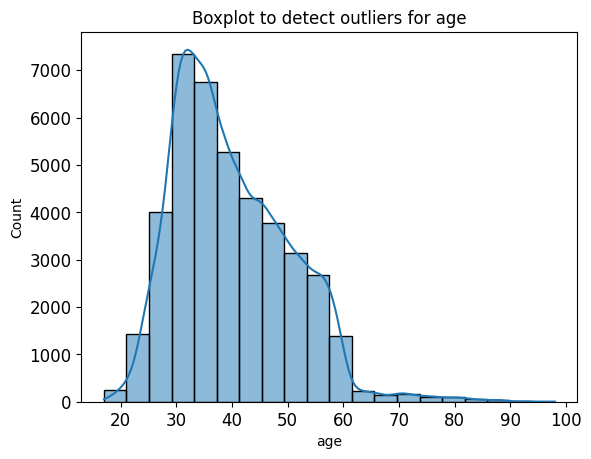

In [7]:
# Create a boxplot to visualize distribution of `age`

sns.histplot(data=term_data, x='age', bins=20, kde=True)
plt.title('Boxplot to detect outliers for age', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

- The data have nearly normal distribution of client ages which may be a great asset for the marketing team.

##### Make a copy of original data

In [8]:
#make a copy of main data
data=term_data.copy()

### Data Preprocessing

##### Check for duplicates

In [9]:
#drop duplicates
data = data.drop_duplicates().reset_index(drop=True)

#non duplicate validation
duplicates = data[data.duplicated()]
duplicates

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y


##### Assess the distribution of classes in the target variable

In [10]:
data['y'].value_counts(normalize=True)* 100

y
no     88.733728
yes    11.266272
Name: proportion, dtype: float64

##### Rename target variable

In [11]:
data.rename(columns={'y': 'subscribe'}, inplace=True)

#validate name chage
data.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribe
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


##### Drop duration column to avoid leakage

In [12]:

data.drop(columns=['duration'], inplace=True)

##### Assess multicollinearity among the independent variables

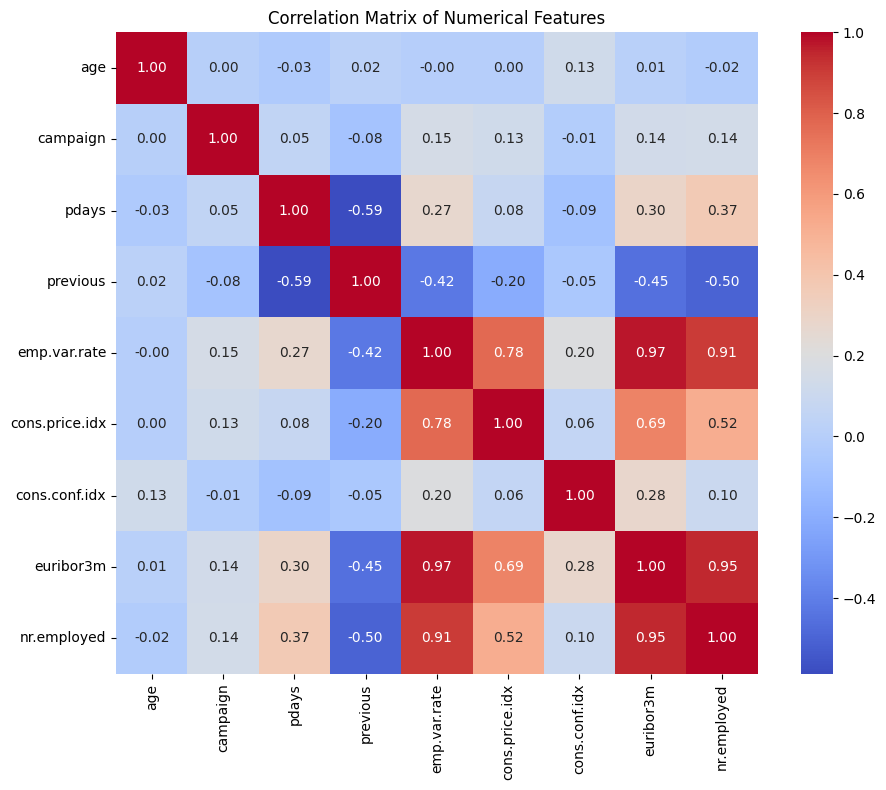

In [13]:

# Select only numerical columns
numerical_data = data.select_dtypes(include=['int64', 'float64'])

#  Create the correlation matrix
corr_matrix = numerical_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()

plt.show()


In [14]:
#drop highly collinear economic indicators
data = data.drop(columns=['emp.var.rate', 'nr.employed'])
data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'subscribe'],
      dtype='object')

- I dropped these columns and retain euribor3m because is general economic indicator


##### Feature engineering

In [15]:
#Check for unique months
data['month'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'mar', 'apr',
       'sep'], dtype=object)

###### Group months into quarterly periods (Q1–Q4) 


In [16]:
#create a function that groups months into their respective yearly quarters
def month_to_quarter(month):
    q1 = ['jan', 'feb', 'mar']
    q2 = ['apr', 'may', 'jun']
    q3 = ['jul', 'aug', 'sep']
    q4 = ['oct', 'nov', 'dec']
    if month in q1:
        return 'Q1'
    elif month in q2:
        return 'Q2'
    elif month in q3:
        return 'Q3'
    else:
        return 'Q4'
        
#create a new column that groups months into quarters
data['year_quarter'] = data['month'].apply(month_to_quarter)


#drop the month variable
data.drop(columns=['month'], inplace=True)

#inspect final output
data['year_quarter'].unique()

array(['Q2', 'Q3', 'Q4', 'Q1'], dtype=object)

######  Bin the 'age' column into categorical age-groups


In [17]:
#  define bins
bins = [0, 30, 50, 70, 100]
labels = ['<30', '30-50', '51-70', '70+']

#create a new column to store binned age
data['age_bin'] = pd.cut(data['age'], bins=bins, labels=labels)

#drop age column
data.drop(columns=['age'], inplace=True)

#inspect final output
data['age_bin'].unique()

['51-70', '30-50', '<30', '70+']
Categories (4, object): ['<30' < '30-50' < '51-70' < '70+']

### Modeling

##### Feature selection



In [18]:
#Convert target variable to binary 
data['subscribe'] = data['subscribe'].map({'yes': 1, 'no': 0})


#  Separate features and target
X = data.drop(columns='subscribe')
y = data['subscribe']

##### Train-test split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.25,
random_state=42)

##### Encode Variables

In [20]:

#  Identify column types
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

#  Build preprocessing for numeric and categorical columns
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
])





##### Create a pipeline for model building

In [21]:
# Create a pipeline with logistic regression
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])



# Cross-validate on training set 
cv_results = cross_validate(
   pipeline,
   X_train,
   y_train,
   cv=5,
   scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
 return_train_score=False
)








##### Train model

In [22]:
#fit the model to the training data
pipeline.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##### Predict



In [23]:

y_pred = pipeline.predict(X_test)


### Initial model evaluation metrics

In [24]:
#Print the evaluation metrics
print("Accuracy:", "%.2f" % accuracy_score(y_test, y_pred))
print("Precision:", "%.2f" % precision_score(y_test, y_pred))
print("Recall:", "%.2f" % recall_score(y_test, y_pred))
print("F1 Score:", "%.2f" % f1_score(y_test, y_pred))

Accuracy: 0.81
Precision: 0.33
Recall: 0.68
F1 Score: 0.44


- Precision and Recall: Shows model quality on the minority class, so how many of the predicted 'yes' were actually yes, and how many of the actual 'yes' were captured, respectively.
- F1 Score: Balances precision and recall



##### Produce a confusion matrix to show the types of error made by the algorithm

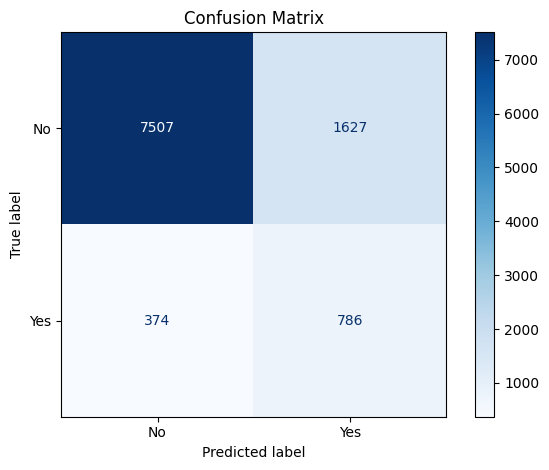

In [25]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()


- True Negatives (top-left): Model correctly said “No, not subscribe” 

- False Positives (top-right): The model incorrectly indicated 'yes' when it should have indicated 'no'. The Marketing team could be chasing the wrong clients.

- False Negatives (bottom-left): The Model missed actual subscriptions. 

- True Positives (bottom-right): Model correctly predicted 786 actual subscriptions.


- Due to the imbalance in the target variable, the model tends to favour predicting the majority class, resulting in a high number of true negatives and a relatively low number of true positives.

##### Feature importance

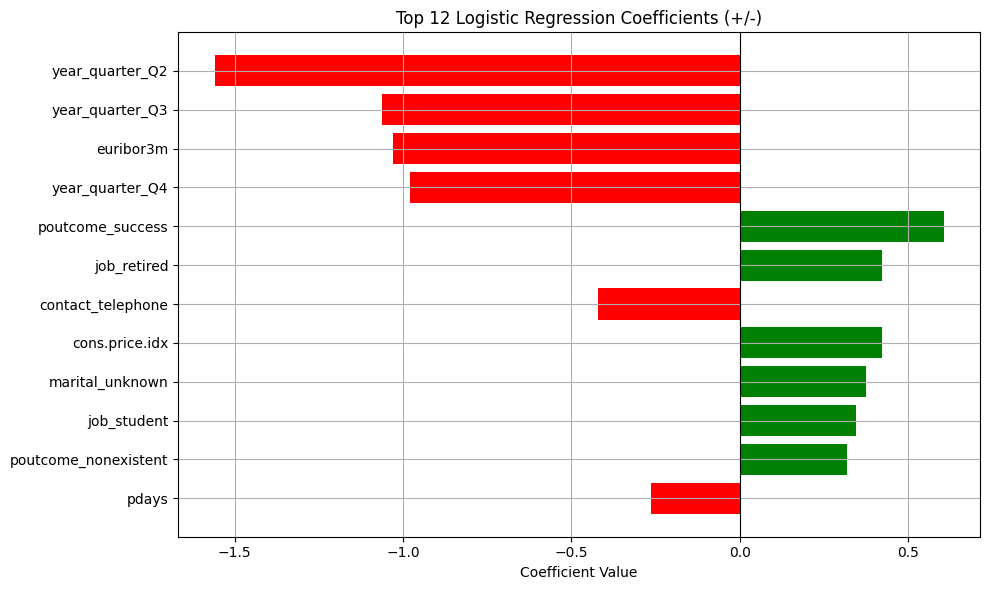

In [26]:
# Get the trained logistic regression model from the pipeline
model = pipeline.named_steps['classifier']

# Get the feature names from the preprocessing pipeline
ohe = pipeline.named_steps['preprocessing'].named_transformers_['cat']
encoded_cat_cols = ohe.get_feature_names_out(categorical_cols)

# Combine numeric and encoded categorical feature names
all_feature_names = numerical_cols + list(encoded_cat_cols)

# Get coefficients from the logistic regression model
coefficients = model.coef_[0]

# Create a DataFrame with feature names and their coefficients
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})

# Sort by actual coefficient values 
top_n = 12
top_features_signed = coef_df.sort_values(by='Coefficient', key=abs, ascending=False).head(top_n)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(top_features_signed['Feature'][::-1], 
                top_features_signed['Coefficient'][::-1], 
                color=['green' if c > 0 else 'red' for c in top_features_signed['Coefficient'][::-1]])

plt.xlabel('Coefficient Value')
plt.title(f'Top {top_n} Logistic Regression Coefficients (+/-)')
plt.axvline(0, color='black', linewidth=0.8)  # vertical line at 0
plt.grid(True)
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')

plt.show()


- Important variables to model’s prediction, regardless of direction.

- Positive coefficients increase cthe hance of y = 1 (subscription)              
- Negative coefficients decrease the chance of y = 1

### Model optimisation (threshold tuning)
This finds the best probability threshold that maximises the F1 score of the model instead of the default 0.5


In [27]:
# Get the predicted probabilities for the positive class 
y_probs = pipeline.predict_proba(X_test)[:, 1]


Best threshold: 0.60
Best F1 Score : 0.48


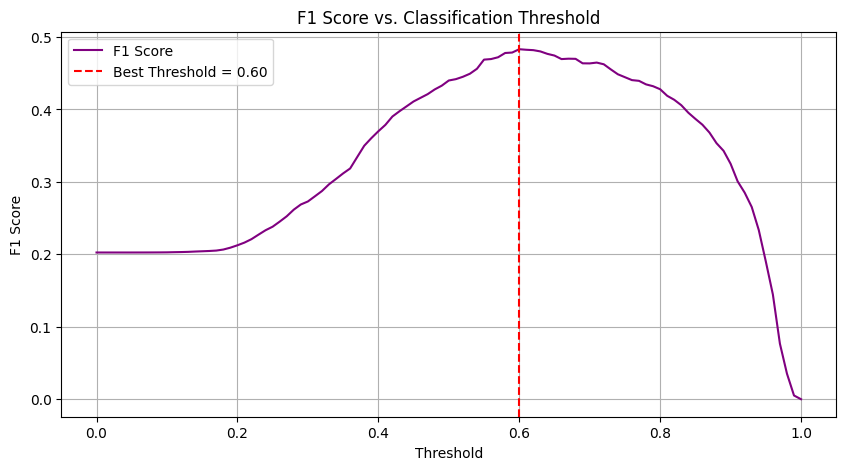

In [28]:
#Creates an array of thresholds 
thresholds = np.arange(0.0, 1.01, 0.01) 

best_threshold = 0
best_f1 = 0
f1_scores = []

for thresh in thresholds:
    y_pred = (y_probs >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh
y_pred_tuned = (y_probs >= best_threshold).astype(int)

print(f"Best threshold: {best_threshold:.2f}")
print(f"Best F1 Score : {best_f1:.2f}")

# plot F1 score and classification threshold graph
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores, label='F1 Score', color='purple')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.title('F1 Score vs. Classification Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.legend()
plt.show()

- The peak of the curve indicates the threshold where the model performs best in terms of balancing precision and recall.

##### Final evaluation after threshold adjustment

In [29]:
# Evaluate using your chosen threshold
print('Precision:','%.2f' % precision_score(y_test, y_pred_tuned))
print('Recall   :','%.2f' % recall_score(y_test, y_pred_tuned))
print('F1 Score :','%.2f' % f1_score(y_test, y_pred_tuned))


Precision: 0.43
Recall   : 0.54
F1 Score : 0.48


- Precision improved, with fewer false positive errors compared to the model using the default threshold, which may result in better targeting (high-confidence leads).

- Recall decreased. The marketing team might not follow up with clients who would have subscribed

- F1 Score improved slightly, which means there's a better balance between precision and recall.




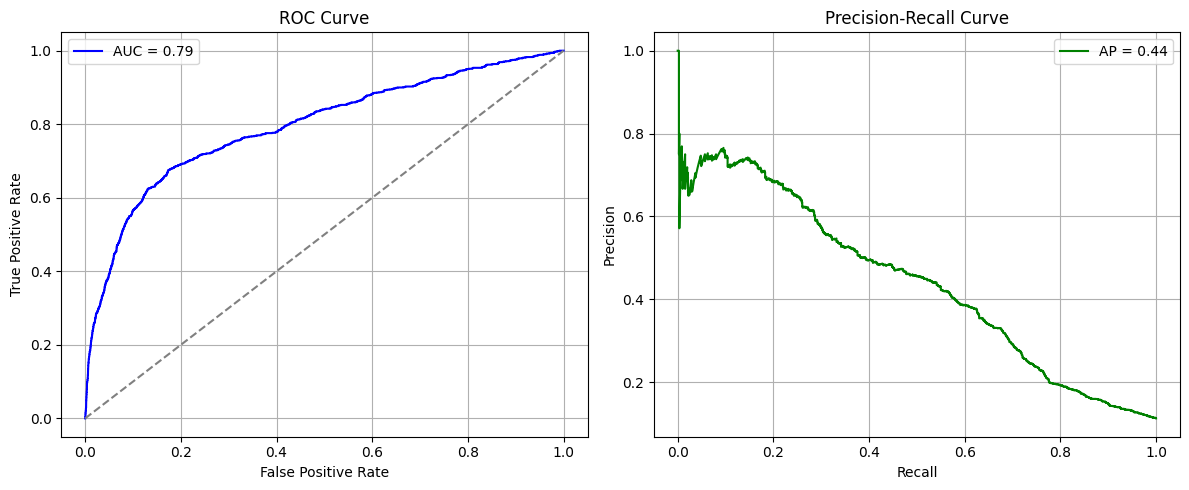

In [30]:
# ROC Curve values
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# Precision-Recall Curve values
precision, recall, _ = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

# Plot side-by-side
plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.legend()

# PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', label=f'AP = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('pr_roc_curve.png', dpi=300, bbox_inches='tight')

plt.show()


- The closer the ROC curve is to the top-left corner, the better the model is at distinguishing between classes, although it is not sensitive to imbalanced data

- PR Curve is more informative for imbalanced datasets, especially when interested in the positive class, or when False positives are costly.

- A high area under the PR curve indicates that your model maintains precision as it recalls more positives.

